In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
#engine connection
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Inspect measurement and station tables 
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])
    
print()    
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print("Last date in dataset:", last_date)

# Calculate the date 1 year ago from the last data point in the database
#https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Timedelta.html - timedelta

last_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)
print("1 year ago from last data point:", last_year_date)


# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year_date).all()
precip_data

Last date in dataset: 2017-08-23
1 year ago from last data point: 2016-08-22


[('2016-08-22', 0.4),
 ('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05'

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(precip_data, columns=["Date", "Precipitation"])
precipitation.head()

# Sort the dataframe by date
precipitation = precipitation.set_index("Date")
precipitation.head()

,Precipitation
Date,
2016-08-22,0.40
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00


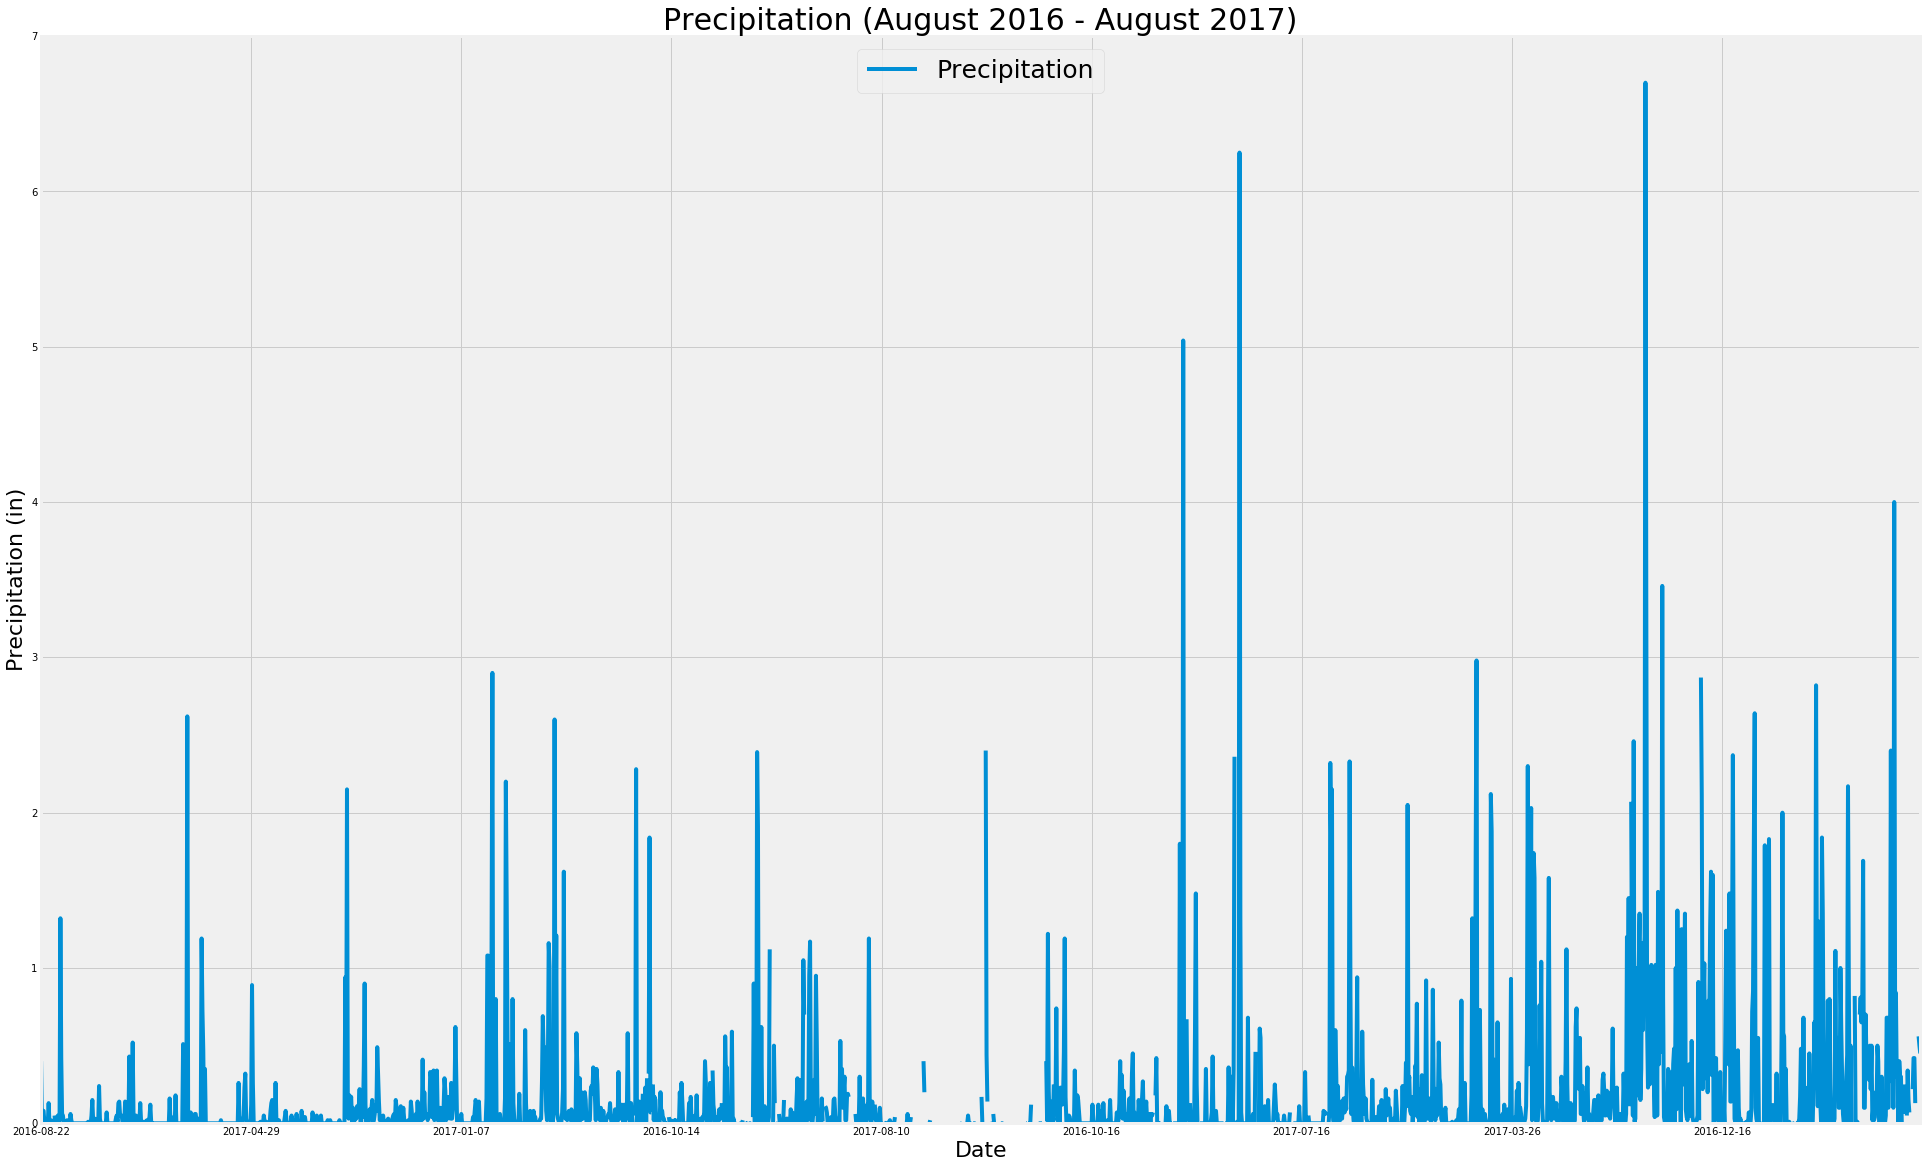

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

ax = precipitation.plot(figsize=(30,20))
ax.set_title("Precipitation (August 2016 - August 2017)", fontsize=30)
plt.xlabel("Date", fontsize=22)
plt.ylabel("Precipitation (in)", fontsize=22)
plt.ylim(0,7)
plt.legend(loc="upper center", fontsize=25)
plt.savefig("precip.png")
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2026.000000
mean,0.179437
std,0.463989
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
number_of_stations = session.query(Station).count()
print("Number of available stations:", number_of_stations)

Number of available stations: 9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

print("Most active stations:")
most_active_stations = session.query((Measurement.station), func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
most_active_stations

Most active stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_activity_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281").order_by(func.min(Measurement.tobs)).all()
most_activity_station

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
highest_temp_obs_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()
highest_temp_obs_station

('USC00519281', 2772)

In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_519281 = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").\
                filter(Measurement.date >= last_year_date).order_by(Measurement.date.desc()).all()
station_519281 = pd.DataFrame(station_519281, columns=["Temperature (F)"])
station_519281.head(10)

,Temperature (F)
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0
5,77.0
6,83.0
7,82.0
8,77.0
9,76.0


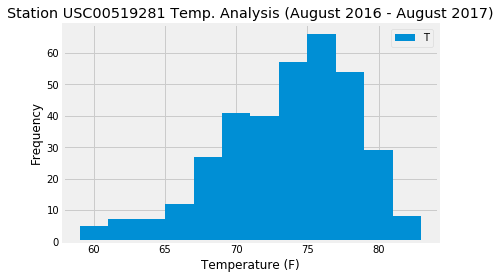

In [57]:
#Histogram

station_temp_histogram = station_519281.hist(bins=12)
plt.title("Station USC00519281 Temp. Analysis (August 2016 - August 2017)")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend("Tobs")
plt.savefig("station_analysis.png")
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates. - Tentative HI trip: 4/15-4/22, 2016 (Easter break)

tmin, tavg, tmax = calc_temps("2016-04-15", "2016-04-22")[0]
print(tmin, tavg, tmax)

[(66.0, 73.19607843137256, 80.0)]


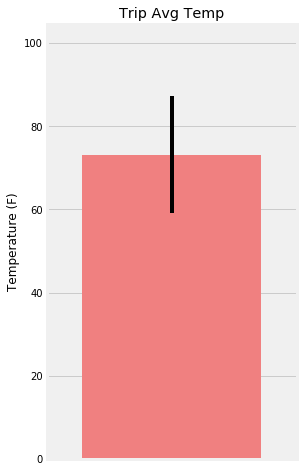

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

xpos = 1
f, ax = plt.subplots(figsize=plt.figaspect(2.))
yerr = tmax-tmin
plt.bar(xpos,tavg,yerr=yerr,color="lightcoral")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temperature (F)")
ax.margins(.2, .2)
plt.savefig("trip_avg_temp.png")